<a href="https://colab.research.google.com/github/yahyakkhalid/Twitter-data-sentiment-analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Téléchargement de bibliothèques

In [ ]:
! pip install -q -U --upgrade scikit-learn==0.24 sklearn statsmodels hypertools pdpbox matplotlib==3.2.2 spacy==3.1.0 nltk==3.2.4 gensim scipy stopwordsiso pyspellchecker textblob_fr vaderSentiment-fr
! pip install -q -U git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git
! pip install -q -U python-Levenshtein # Le module d'extension C contient des fonctions pour accélérer le calcul (word2vec, fasttext...)
! pip install -q -U gdown

# Script de création de corpus
### *https://github.com/yahyakkhalid/Twitter-data-sentiment-analysis/blob/main/creation_corpus.ipynb*

# Téléchargement de corpus (résultat du script)

In [ ]:
! gdown --id 1FrMd6HSVlLSk0Dj7fv-qJcZ0s9ZpNtVV

Downloading...
From: https://drive.google.com/uc?id=1FrMd6HSVlLSk0Dj7fv-qJcZ0s9ZpNtVV
To: /content/corpus_tweets.zip
100% 110M/110M [00:01<00:00, 102MB/s]


# Importation des bibliothèques

In [ ]:
import os
from zipfile import ZipFile

import re
import pandas as pd
import numpy as np

from multiprocessing import cpu_count

import matplotlib.pyplot as plt

from spellchecker import SpellChecker
from spacy.lang.fr import stop_words as fr_stop
import stopwordsiso

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

from sklearn.manifold import TSNE

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
from textblob.sentiments import NaiveBayesAnalyzer

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_curve

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

# Extraction du corpus

In [ ]:
with ZipFile('corpus_tweets.zip', 'r') as zf:
    zf.extractall('./')

# Telechargement des bibliothèque de NLTK

- punkt: NLTK tokenizer
- stopwords
- movie_reviews: dataset pour l'analyseur de sentiments naïf bayes
- vader_lexicon: outil d'analyse de sentiments basé sur des règles et un lexique

In [ ]:
nltk.download(['punkt', 'stopwords', 'movie_reviews', 'vader_lexicon'], quiet = True)

True

# Création d'un répertoire pour l'exportation de données

In [ ]:
export_dir = 'exports/'
if not os.path.isdir(export_dir):
   os.mkdir(export_dir)

# Importation et chargement du corpus

In [ ]:
corpusdir = 'corpus_tweets/'
data = []

for filename in os.listdir(corpusdir):
  with open(corpusdir + filename, mode='r') as file:
    data.append(file.read())

tweets_df = pd.DataFrame(data, columns = ['tweet'])

In [ ]:
print(f'{tweets_df.shape[0]} tweets')

300000 tweets


# Supprimer les tweets en double

In [ ]:
print(f'{len(tweets_df.loc[tweets_df.duplicated()])} duplicated tweets')

4599 duplicated tweets


In [ ]:
tweets_df.drop_duplicates(inplace = True)

# Un échantillon des tweets 

In [ ]:
pd.set_option('display.max_colwidth', None)

tweets_df.sample(10)

,tweet
70932,@Orange_France J’y suis pour rien
4114,"Le délire covidient se poursuit!\nMonument des anciens combattants vandalisé pendant le jour du souvenir.\n""Les vrais héros sont les vaccinés"" \n#polqc #polcan #COVID19 #coronavirus #PassSanitaire\nhttps://t.co/X1VngUAQQx"
102190,10 janvier 2021 #COVID19 \n\n600 enfants hospitalisés +45% en une semaine. \n92 réas +40% en une semaine\n\n#Ecole #ReinfoCovid #Blanquer #Omicron https://t.co/09vmGlMsuR
120058,Si @Qofficiel a une audience en baisse c'est à cause de cette brigade culture que personne ne comprends #Quotidien #1Octubre #COVID19
53928,"Bientôt en France, les non-vaccinés vont dire qu'ils se traitent à l'urine, vu qu'ils pompent tous leurs autres arguments aux terre-platistes ricains ...\n\n#nonvacciné #COVID19 \n#FlamesuitOn https://t.co/qNYDA7UIsU"
280642,"#Blanquer &amp; #Castex, les #PipeauEtMario du @gouvernementFR.\n\n#JeSoutiensLaGreveDu13Janvier #MacronLeFou #Greve13Janvier #ProtocoleTousInfectes #protocolesanitaire #ecole #COVID19 #TPMP https://t.co/F6Tr8kwCrq"
223992,"PLAN LARGE | Historien de l'économie à l'Université Columbia, Adam Tooze est historiographe de crises qui ne sont pas terminées. À propos du #covid19, il se demande: ""Où se trouve le plan pour #vacciner la population mondiale?""\n➡ https://t.co/Ua7oMVOQ6y\n✍️ Par @RoelVerrycken https://t.co/8EBX70Vs3Z"
236923,Pas besoin de vaccination début 2022. Ils l’auront tous chopé d’ici là nos enfants. #COVID19 https://t.co/xO8118iw1D
126814,"L’expansion spectaculaire du variant Omicron perturbe déjà les secteurs des transports, notamment en raison de la multiplication des arrêts maladie. 😷\nhttps://t.co/TYnMdoB7Jq\n#COVID19 #Omicron"
145595,"C'est pas pour mettre de l'huile sur le feu mais est-ce que le vaccin c'est pas un peu de la vente forcée ? #COVID19\n""Vente forcée : Qu'est-ce que c'est ? Comment la faire annuler ? - https://t.co/zGJ3bKWqXH"" https://t.co/CDILOxAsHz"


In [ ]:
tweets = tweets_df.copy()

# Traitement des émojis

## Décodage ses emojis et les traduire en français

### Demande de récuperation des émojis au site :
> https://emojiterra.com/fr/points-de-code

In [ ]:
import urllib.request
from bs4 import BeautifulSoup

user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
url = "https://emojiterra.com/fr/points-de-code/"
headers = {'User-Agent': user_agent} 

request=urllib.request.Request(url, None, headers)
response = urllib.request.urlopen(request)
data = response.read()

### Récupération du tableau des émojis

In [ ]:
soup = BeautifulSoup(data, 'html.parser')
table = soup.find('table')
emojis_df = pd.read_html(str(table))[0]

In [ ]:
emojis_df.sample(10)

,#,Emoji + Unicode CLDR Short Name,Point(s) de code Unicode
1461,1462,#️⃣ Touches : #,U+23 U+FE0F U+20E3
523,524,🐈‍⬛ Chat Noir,U+1F408 U+200D U+2B1B
2978,2979,🧖🏽‍♂️ Homme Au Hammam : Peau Légèrement Mate,U+1F9D6 U+1F3FD U+200D U+2642 U+FE0F
2085,2086,👩🏿 Femme : Peau Foncée,U+1F469 U+1F3FF
1467,1468,4️⃣ Touches : 4,U+34 U+FE0F U+20E3
1909,1910,☝🏾 Index Pointant Vers Le Haut : Peau Mate,U+261D U+1F3FE
2197,2198,🙆🏼 Personne Faisant Un Geste D’acceptation : Peau Moyennement Claire,U+1F646 U+1F3FC
3300,3301,👨🏼‍🤝‍👨🏿 Deux Hommes Se Tenant La Main : Peau Moyennement Claire Et Peau Foncée,U+1F468 U+1F3FC U+200D U+1F91D U+200D U+1F468 U+1F3FF
154,155,💭 Bulle De Pensée,U+1F4AD
331,332,👲 Homme Avec Casquette Chinoise,U+1F472


### Séparation des emojis de leurs textes respectifs

In [ ]:
emojis_table = emojis_df['Emoji + Unicode CLDR Short Name'].values.tolist()
emojis = {}
for line in emojis_table:
  emoji, text = line.split(' ', 1)
  emojis[emoji] = text

In [ ]:
emojis.get('😇')

'Visage Souriant Avec Auréole'

## Définition d'une fonction qui convertit les emojis récupérés en texte

In [ ]:
def demojize(text):
  global emojis
  words = text.split()
  for idx, word in enumerate(words):
    word_ = ''
    for char in word:
      if char in emojis.keys():
        char = " " + emojis[char] + " "
      word_ += char
    words[idx] = word_
  return " ".join(words)

### Test de la fonction

In [ ]:
demojize('😁vaccin 😁😇 Bon, 😉')

' Visage Souriant Aux Yeux Rieurs vaccin  Visage Souriant Aux Yeux Rieurs  Visage Souriant Avec Auréole  Bon,  Visage Faisant Un Clin D’œil '

## Conversion des emojis en texte pour l'analyse des sentiments

In [ ]:
tweets['tweet_emojis'] = tweets['tweet'].apply(lambda tweet: demojize(tweet))

# Test de subjectivité

## *Simple french analyzer*

In [ ]:
tb_fr = Blobber(pos_tagger = PatternTagger(), analyzer = PatternAnalyzer())
tweets['subjectivité'] = tweets['tweet_emojis'].apply(lambda tweet: tb_fr(tweet).sentiment[0])

In [ ]:
tweets.sample(10)

,tweet,tweet_emojis,subjectivité
19709,Avec la #COVID19 le #bib a connu un franc succès dans les linéaires. Découvrez les lauréats du concours des #vins qui leur ait dédié.\n\nhttps://t.co/k94muoMFlL,Avec la #COVID19 le #bib a connu un franc succès dans les linéaires. Découvrez les lauréats du concours des #vins qui leur ait dédié. https://t.co/k94muoMFlL,0.4000
241780,"L'#Aspirine, l'#HydroxyChloroquine, le #Zinc, l'#ivermectin, ... pleins de traitements précoces marchent contre le #COVID19. Mais depuis le début, les #NoFakeMed, les ""du côté de la science"" ont préféré tuer en refusant de soigner plutôt que sacrifier les bénéfices de #BigPharma! https://t.co/Lrvk5gA64h","L'#Aspirine, l'#HydroxyChloroquine, le #Zinc, l'#ivermectin, ... pleins de traitements précoces marchent contre le #COVID19. Mais depuis le début, les #NoFakeMed, les ""du côté de la science"" ont préféré tuer en refusant de soigner plutôt que sacrifier les bénéfices de #BigPharma! https://t.co/Lrvk5gA64h",0.4425
206401,J’ai loupé quelque chose ? La #4emedose ça y est c’est fait ou pas ?\n➡️ COVID 1/10/20\n➡️ Pfizer 5/04/21\n➡️ Pfizer 6/11/21 (expiration 8/06/22 ?)\nSchéma vaccinal complet on est d’ac? Alors pourquoi TousAntiCovid me dit que je suis éligible au rappel vaccinal le 6/02/22 ? #COVID19,J’ai loupé quelque chose ? La #4emedose ça y est c’est fait ou pas ? ➡️ COVID 1/10/20 ➡️ Pfizer 5/04/21 ➡️ Pfizer 6/11/21 (expiration 8/06/22 ?) Schéma vaccinal complet on est d’ac? Alors pourquoi TousAntiCovid me dit que je suis éligible au rappel vaccinal le 6/02/22 ? #COVID19,0.4300
205053,Nouvelle fermeture des lieux de culte au Togo\nDurée : 1 mois\n#Covid19 #eglise https://t.co/CA7tQ1FrxB,Nouvelle fermeture des lieux de culte au Togo Durée : 1 mois #Covid19 #eglise https://t.co/CA7tQ1FrxB,0.1000
9649,Pass vaccinal : ce que contient le projet de loi présenté à l'Assemblée nationale ce mercredi.\n#Coronavirus #Covid19 #Vaccin #Vaccination #Variant #Omicron #PassVaccinal #AssembléeNationale \nhttps://t.co/S2F0UDqsJO,Pass vaccinal : ce que contient le projet de loi présenté à l'Assemblée nationale ce mercredi. #Coronavirus #Covid19 #Vaccin #Vaccination #Variant #Omicron #PassVaccinal #AssembléeNationale https://t.co/S2F0UDqsJO,0.0000
71102,"4/9) #CATALOGNE #BARCELONE #POSITIVITE #COVID19 publiée aujourd'hui, 09/09 10h02\nPositivité auj. et vérifiée le 05/09:\nCatalogne: auj. 🔴3.80↑ (+0.35), date vérifié: 🟢3.57↓ (-0.02↑).\nBarcelone: auj. 🟢3.47↓ (-0.82), date vérifié: 🟢3.41↓ (-0.05↑).\nSource @salutcat https://t.co/oH2BkqDW4n","4/9) #CATALOGNE #BARCELONE #POSITIVITE #COVID19 publiée aujourd'hui, 09/09 10h02 Positivité auj. et vérifiée le 05/09: Catalogne: auj. Disque Rouge 3.80↑ (+0.35), date vérifié: Disque Vert 3.57↓ (-0.02↑). Barcelone: auj. Disque Vert 3.47↓ (-0.82), date vérifié: Disque Vert 3.41↓ (-0.05↑). Source @salutcat https://t.co/oH2BkqDW4n",0.0025
18331,"Après trois jours de débats houleux et de propos vulgaires du président #Macron, les #législateurs français ont approuvé le #passvaccinnal qui divise, conçu pour ""emmerder "" les #nonvaccinés. Certains envisagent une grève générale voire une révolution #Covid19 #macronIndigne https://t.co/87XuTZA1VM","Après trois jours de débats houleux et de propos vulgaires du président #Macron, les #législateurs français ont approuvé le #passvaccinnal qui divise, conçu pour ""emmerder "" les #nonvaccinés. Certains envisagent une grève générale voire une révolution #Covid19 #macronIndigne https://t.co/87XuTZA1VM",-0.0525
299913,Y’a plus rien de logique dans cette histoire de #COVID19 https://t.co/yObAhhBsXH,Y’a plus rien de logique dans cette histoire de #COVID19 https://t.co/yObAhhBsXH,0.1250
173440,Les lieux de cultes fermés aussi…Moi j’aimerais être un petit oiseau dans Outremont demain soir !\n#CouvreFeu #COVID19 #Omicron,Les lieux de cultes fermés aussi…Moi j’aimerais être un petit oiseau dans Outremont demain soir ! #CouvreFeu #COVID19 #Omicron,-0.0775
8115,"La folie, conséquence de la peur.\nLa peur conséqu

> Un score élevé de *subjectivité* indique qu'il s'agit principalement d'une opinion publique et non d'une information factuelle.

## Filtrer les tweets subjectifs
- Seuil (*Threshold*) : 35%

In [ ]:
tweets = tweets[tweets['subjectivité'] >= 0.35]

In [ ]:
print(f'{tweets.shape[0]} tweets subjectives')

18747 tweets subjectives


In [ ]:
tweets.drop('subjectivité', axis = 1, inplace = True)
tweets.reset_index(inplace = True, drop = True)

# Analyse des sentiments

> On va tester deux analyseur des sentiments du langage française.

## *Simple analyzer*

### Mesure de la polarité

In [ ]:
tweets['polarité_simple'] = tweets['tweet_emojis'].apply(lambda text: tb_fr(text).sentiment[1])

### Déduction du sentiment à partir de coefficient de polarité

In [ ]:
tweets['sentiment_simple'] = tweets['polarité_simple'].apply(lambda x: 'Negative' if x < 0 else ('Neutre' if x == 0 else 'Positive'))

In [ ]:
tweets[['tweet', 'sentiment_simple']].sample(10)

,tweet,sentiment_simple
2765,"Merci! Surtout que c’est du bénévolat! L’expérience est riche et enrichissante: écrans au sol, carrelage au sol pensé en 15x15 pour les robots, tables avec surface en lego(R)… 🚧 Et ce n’est qu’un 10ème de ce qu’il y aura… et contrainte Covid19: des surfaces antibactériennes 🦠 https://t.co/LqQxAA75QU",Positive
12296,"Très intéressant reportage, à voir jusqu’au bout. 🙂 @LeTemps #Covid19 #parole #de #nonvaccinés #avis #compréhension #empathie #calmer #les #choses https://t.co/mlXOXsQ5G6",Positive
18228,"#WebJournal - Jean le Comique, alias Jean le Jambon prend les Gens pour des C 🤣🤣🤣🤣🤣 #Covid19 #PassSanitaire #Vaccin #Masque #Confinement #CouvreFeu #Attestation #Manipulation #Propagande https://t.co/ZQJaGbFUd4",Positive
18055,Le #covid19 nous rappelle l’intérêt d’un système de santé solidaire solide et d’une remise en question d’une gestion entrepreneuriale de l’hôpital https://t.co/qYzZYbrCHu,Positive
15265,#Vaccination #COVID19 | Au 6 octobre :\n✔ 50 717 642 personnes ont reçu une première injection\n✔ 48 982 309 personnes ont un schéma vaccinal complet,Positive
3894,Bravo à tous et un rapport d’activités impressionnant ! merci @jrdicom @ICOM_France @emiliegirard21 pour votre action durant la période #COVID19 #confinement @IcomOfficiel @MinistereCC https://t.co/rOLBUv3Eec,Positive
5313,#COVID19 | Communiqué de presse : point sur la situation en #Dordogne au 14 janvier 2022\n&gt; Ouverture de 3 centres de dépistage\n&gt; Accélération de la vaccination\n&gt; Accueil des enfants des personnels indispensables à la gestion de crise\n🗞️Lire le communiqué ➡️https://t.co/ktF7KRF41N https://t.co/hGAqgxGgd1,Positive
2620,bon en attendant notre poto le #COVID19 il va pouvoir monter une équipe de foot avec tout c'est collègue variants.,Positive
5347,"#Quebec #Covid19 \nMalgré la gestion catastrophique de la pandémie et l’improvisation ,47% de la population préfère #Legault !!! ce qui nous amène à conclure que 47% de la population sont des MOUTONS 🤓🤓🤓 https://t.co/BKuFtGPLdj",Positive
5102,"#FLASHINFO \nJohn Denton,@ICCSecGen, affirme que malgré les souffrances de l'économie réelle à cause de la #Covid19 et du #changementclimatique, le fait que l'Arabie saoudite ait jugé bon de se concentrer sur ce secteur de valeur très important dans le #tourisme est essentiel https://t.co/UW6P5VGRPD",Positive


## *VADER* (Valence Aware Dictionary et sEntiment Reasoner)

> Le *compound score* est la somme des scores positifs, négatifs et neutres, le score est ensuite normalisé entre -1 (négatif le plus extrême) et +1 (positif le plus extrême)

In [ ]:
SIA = SentimentIntensityAnalyzer()
tweets['polarité_vader'] = tweets['tweet_emojis'].apply(lambda text: SIA.polarity_scores(text)['compound']) # compound = agrégé

In [ ]:
tweets['sentiment_vader'] = tweets['polarité_vader'].apply(lambda x: 'Negative' if x < 0 else ('Neutre' if x == 0 else 'Positive'))

> Plus le *compound score* est proche de +1, plus la positivité du texte est élevée

In [ ]:
tweets[['tweet', 'sentiment_simple', 'sentiment_vader']].sample(10)

,tweet,sentiment_simple,sentiment_vader
17824,L’obligation du port du masque à l’école primaire sera levée à partir du 4 octobre dans les départements les moins touchés par l’épidémie de #COVID19. La #Mayenne pourrait être concernée.\n\nhttps://t.co/Mv33z3gt9v,Positive,Positive
6551,Très étonnant le mutisme des artistes !!!!!!!#COVID19 #NonAuPassSanitaire,Positive,Positive
1404,"@Conseil_Etat En L3 droit j'avais eu comme question ""le conseil d'Etat est il un garant de nos libertés ? Aujourd'hui ma réponse serait différente si je devais y répondre, elle ressemblerait plutôt à ça : 🤣🤣🤣🤣🤣🤣🤣\n#PassDeLaHonte\n#VeranDemission\n#VeranenPrison \n#PassSanitaire \n#COVID19",Positive,Positive
861,"« Le médecin infectiologue-hygiéniste nous démontre comment dans une telle crise épidémique, les meilleures molécules pour soigner sont souvent mises de côté au profit des grandes entreprises pharmaceutiques. » #covid19 #CovidHysteria https://t.co/WSi7gyGi0Y",Positive,Negative
16952,"Cette année, la @Banquemondiale a approuvé 35 nouvelles opérations dans la région #MENA, dont des opérations axées sur la riposte à la #COVID19 ainsi que celles axées sur les investissements intelligents face au changement climatique. Décryptage. https://t.co/jnM11Qj7OQ #covid19 https://t.co/TVq1CSwKWN",Positive,Positive
1898,#macron #COVID19 #passedelahonte Attention à tous! Le 24 décembre au soir au repas avec vos grands-parents et vos enfants ! Il y aura une expérience scientifique il faudrait qu'un grand nombre de personnes visualise l'enterrement de Macron ! Dû à un AVC..... Je compte sur vous,Positive,Positive
14659,"Allez, on essaie d'ouvrir les yeux et de se poser les bonnes questions !\n#COVID19 #CriseSanitaire\nhttps://t.co/jvj452OUuz",Positive,Positive
12194,@BenjaminCauchy #Salomon ...Je croyais qu'il avait été mis au placard ‼️😁 #Véran #COVID19 #5èmeVague ... https://t.co/AZ0abPFEtI,Positive,Positive
18139,✅ Dose de rappel reçue. 💉\n\nC’est l’addition de nos actions individuelles qui fera que nous lutterons efficacement collectivement contre la #COVID19 et que nous préserverons notre système de santé.\n\nMerci aux HCL pour l’organisation parfaite du centre de vaccination de Gerland! https://t.co/GdlzNY7nfP,Positive,Positive
4937,"@JeanCASTEX @R_Bachelot @gouvernementFR @MinistereCC @MuseeLouvre @leCMN #JacobDesvarieux de #Kassav feu apologiste de la piqûre covid19 piqué 3 doses et dead, ses défenses immunitaires naturelles ravagées détruites éradiquées.\nNous vous avons compris 5/5",Positive,Negative


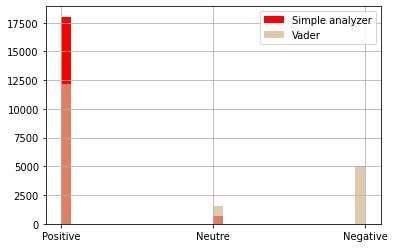

In [ ]:
tweets['sentiment_simple'].hist( bins = 30, color = 'red', alpha = 1)
tweets['sentiment_vader'].hist( bins = 30, color = 'tan',  alpha = 0.7)
plt.legend(["Simple analyzer", "Vader"])

> *Simple Sentiment Analyzer* ne donne pas de résultats exacts, et ne fait pas la distinction entre les opinions et les informations factuelles, par contre *Vader* donne des résultats plus précis.

In [ ]:
tweets.drop(['tweet_emojis', 'polarité_simple', 'sentiment_simple', 'polarité_vader'], axis = 1, inplace = True)
tweets.rename(columns = {'sentiment_vader': 'sentiment'}, inplace = True)

In [ ]:
tweets.sample(10)

,tweet,sentiment
3089,Erika Vlieghe en faveur d'un test aussi pour les vaccinés.\nSpéciale dédicace à tous ceux qui se sont fait vacciner pour retrouver leur liberté ou pour obtenir le #CovidSafeTicket en vue d'un retour à la vie d'avant.\n#COVID19\n#3emeDose \n#vaccination https://t.co/6JgYuHsEdd,Positive
10805,"#COVID19 - En date du 20 décembre, voici la situation au Québec: https://t.co/pwoUoaBgaF\n\nVaccination 5-11 ans: À ce jour, 347 418 jeunes ont reçu une première dose du vaccin contre la COVID-19 et 21 516 attendent leur rendez-vous. https://t.co/zwlwH3qw26",Neutre
13209,“Qui blâme autrui doit être pur..\n#OrdredesMedecins \n#Raoult \n#COVID19 \n#médecin https://t.co/VV29OYTjXV,Negative
10420,"@Skandyne Hihi merci Karin 🥰 quels sont les produits que vous attendez ? N'hésitez pas à me dire en DM, car il y a des ruptures d'approvisionnement pour certains produits cette année ( #COVID19 😬)",Positive
9251,@AdresanSophie Patrick Bruel était un monument de la chanson française. Il vient de s'effondrer.\nAu lieu de rassembler il a souhaité diviser.\nAllez salut Patrick bonne retraite !\n#PatrickBruel #Bruel @PatrickBruel\n #COVID19 #Covid_19 #COVID19France #Covid \n#VaccinationCovid #Vaccination #Vaccin,Positive
7307,Un obèse alcoolique qui viens nous expliquer ce qui est bon pour notre santé... \n\nWhy not.\n\n#COVID19 https://t.co/NU4zLUWbxf,Positive
17738,"Et c’est bon j’ai trouvé la solution on peut sauver l’humanité, retour à la vie normal @EmmanuelMacron et @olivierveran #COVID19 😝 https://t.co/F2sQZqJBCZ",Positive
6221,#complotisme ou cntre la pensée unique un témoignage d'un député aux US #covid19 https://t.co/pD2IATg856,Positive
16919,"Une belle édition #SIGNAUX21 où nous avons réfléchi ensemble sur les tendances qui ont émergé avec le #COVID19, à nous de faire demain ! Merci @lpg @bertinalexandre HB @UNITEC_Bdx https://t.co/zpNVaMu8yw",Positive
18319,"L’ère du soupçon, avec le #Pfizergate tout le monde sait mais personne ne dit rien !!!\n\n#cnews #lci #bfm #TPMP #OEED #TheVoiceAllStar #DALS11 #DALS #arte #france2 #rn #lrem #btp #BFMdebat #amour #COVID19 #septahuit #tf1 #macron20h #Manifs6novembre",Positive


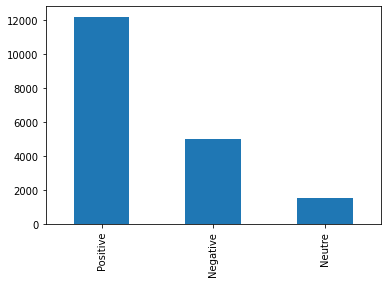

In [ ]:
tweets['sentiment'].value_counts().plot.bar()

> En moyenne, l'opinion des francophones sur la situation covid est positive.

## Exportation des tweets avec les sentiments que nous avons obtenus

In [ ]:
! pip install -q -U openpyxl
tweets.to_excel(export_dir + 'tweets_sentiment_data.xlsx', index = False)

# Prétraitement

## Chargement des *Stop-words*

#### Chargement des *Stop-words* français

In [ ]:
stopwords = nltk.corpus.stopwords.words('french')
len(stopwords)

157

In [ ]:
stopwords = fr_stop.STOP_WORDS
len(stopwords)

507

#### Étant donné que les *Stop-words* de NLTK et Spacy ne sont pas nombreux, nous allons les importer d'une source différente

In [ ]:
stopwords = stopwordsiso.stopwords("fr")
len(stopwords)

691

#### Nous pouvons ajouter d'autres *Stop-words*

In [ ]:
stopwords.update({'janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre'})
stopwords.update({'lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche'})
stopwords.update({'aaaaah', 'aaaah'})

## Suppression des noms personnels

In [ ]:
names = []
table = pd.read_table('https://www.usna.edu/Users/cs/roche/courses/s15si335/proj1/files.php%3Ff=names.txt&downloadcode=yes', header = None)
names.extend([name.lower() for _ in table.values.tolist() for name in _])
names = set(names)

## Correcteur d'orthographe

In [ ]:
spell = SpellChecker(language = 'fr')
spell.word_frequency.load_words(['covid']) # autoriser d'autres mots non français

## French Lemmatizer

In [ ]:
lemmatizer = FrenchLefffLemmatizer()

## French Stemmer

In [ ]:
stemmer = SnowballStemmer('french')

## Nettoyage

- Suppression des identifiants Twitter (@user)
- Suppression des URLs du texte
- Suppression des hashtags
- Suppression des ponctuations, des chiffres et des caractères spéciaux
- Suppression des émojis
- Suppression des mots de longueur <= 3
- Suppression des *Stop-words*
- Supprimer des noms de personnels
- Filtrer les mots français
- Correction d'orthographe
- Lemmatisation
- Stemming

In [ ]:
def nettoyage(text):
  global stopwords
  global names
  global spell
  global lemmatizer
  global stemmer

  text = re.sub(r'@[\w]*', '', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'#[\w]*', '', text)
  text = re.sub(r'[^A-Za-z#çéâêîôûàèìòùëïü\-]', ' ', text)
  text = [word for word in word_tokenize(text.lower()) if word not in stopwords and len(word) > 3]
  text = [word for word in text if word not in names]
  text = [word for word in text if word not in spell.unknown(text)]
  text = [spell.correction(word) for word in text]
  text = [lemmatizer.lemmatize(word, 'n') for word in text]
  text = [stemmer.stem(word) for word in text]

  return " ".join(text)

In [ ]:
tweets['processed_tweet'] = tweets['tweet'].apply(lambda tweet: nettoyage(tweet))

In [ ]:
tweets.sample(10)

,tweet,sentiment,processed_tweet
5771,"Quatremer est bon quand il fait du journalisme … sur le COVID19, je zappe.. https://t.co/4isEbzsnlU",Positive,journal covid zapp
17197,@Mediavenir Sans déconner 😅 ... Déjà que les antivax covid19 sont contre + les vaccinés contre le pass de la dictature... Évidemment que tt ce cassea gueule,Positive,décon déjà covid vaccin pass dictatur gueul
10637,Bon à savoir...\n#cantotalenergies2021 #Covid19 #coronavirus https://t.co/hZD1jcfFwP,Positive,savoir
14607,"T'envoyer aux oubliettes de l'Histoire est une nécessité !\n\nLa pension de retraite, c'est pour nous (on est bons joueurs).\n\n#castex #France #COVID19 #gestion #BFMTV #TouchePasAuxEnfants #TouchezPasAuxEnfants \n#VaccinationEnfants #VaccinationObligatoire https://t.co/4vehHleG1l",Positive,envoi oubliet histoir nécess pension retrait bon joueur
7001,"10 mars 2020: le gouv. Legault dépose un budget radieux \n11 mars: le rumeur court, l'épidémie de #COVID19 19 approche\n12 mars: 1re conf. Legault-Arruda\n...#Pandemie...\n25 nov. 2021: Minibudget radieux du gouv. Legault\n26 nov: on découvre le #Omicron\n27 nov: ..😬...\n#polqc #poisse",Positive,dépos budget radieux rumeur court épidem approch conf radieux découvr
10938,"Dans une salle de la fonction publique, des sièges condamnés à mort à cause du #COVID19 🤣🤣🤣 https://t.co/GvSR1CqVNW",Positive,sall fonction publiqu sieg condamn mort caus
7702,@IamXoriGG @EtIsmaelle @Poulin2012 Le vaccin contre la grippe a été inventé il y a 70 ans.....\nIl est fort à parier que le #COVID19 va monter et descendre longtemps !,Negative,vaccin gripp invent fort pari mont descendr
6198,#Covid19 #Legault \nBon Dimanche les MOUTONS sans vous notre “Pays” le #Quebec n’aura aucun sens 😂😂😂 https://t.co/aReiV68cka,Negative,mouton pay sen
3003,"Meilleurs voeux à chacune et chacun d’entre vous. En 2022, après cette année 2021 marquée par la #COVID19, la Région @hautsdefrance continuera à se battre pour vous. #BonneAnnée2022 https://t.co/wSV0iGknUN",Neutre,meilleur voeu anné marqu région continu battr
2411,Israël 🇮🇱 \n\nLes hospitalisations #COVID19 2021 vs. 2020\nEncore une 1/2 douzaine de rappels #vaccinationCovid et cela sera peut-être efficace \n#vaccination #Vaccin #vaccins https://t.co/mNhMd819Db,Positive,israël hospitalis douzain rappel efficac


# Modèles de représentation

## Diviser les données

In [ ]:
X = tweets['processed_tweet']
y = tweets['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Tokénisation

In [ ]:
word_tokens = X.apply(lambda tweet: word_tokenize(tweet))
train_tokens = X_train.apply(lambda tweet: word_tokenize(tweet))
test_tokens = X_test.apply(lambda tweet: word_tokenize(tweet))

## Modèles de représentation

### BoW - *Bag-of-Words*

In [ ]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

### Word2Vec

In [ ]:
w2vec_model = Word2Vec(vector_size = 300, window = 20, workers = cpu_count())
w2vec_model.build_vocab(word_tokens)
w2vec_model.train(word_tokens, total_examples = len(word_tokens), epochs = 15)

(1764254, 2112375)

### Fast Text

In [ ]:
fastText_model = FastText(vector_size = 300, window = 20, workers = cpu_count())
fastText_model.build_vocab(word_tokens)
fastText_model.train(word_tokens, total_examples = len(word_tokens), epochs=15)

(1764106, 2112375)

### Representation

In [ ]:
def get_embedding(model, words):
  valid_words = [word for word in words if word in model.wv.index_to_key]
  if valid_words:
      embedding = np.zeros((len(valid_words), 300), dtype=np.float32)
      for idx, word in enumerate(valid_words):
          embedding[idx] = model.wv[word]

      return np.mean(embedding, axis=0)
  else:
      return np.zeros(300)

def vectoriser_avg(model, X):
  X_embeddings = np.array([get_embedding(model, words) for words in X])
  return X_embeddings


> Pour chaque document (tweet), on calcule la somme des vecteurs associés aux mots qui le composent, on met des zéros si le mot n'est pas dans le vocabulaire

## Vectorisation des données d'entrainement et du test

In [ ]:
X_train_w2v = vectoriser_avg(w2vec_model, train_tokens)
X_test_w2v = vectoriser_avg(w2vec_model, test_tokens)

In [ ]:
X_train_ftxt = vectoriser_avg(fastText_model, train_tokens)
X_test_ftxt = vectoriser_avg(fastText_model, test_tokens)

### Visualisation

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

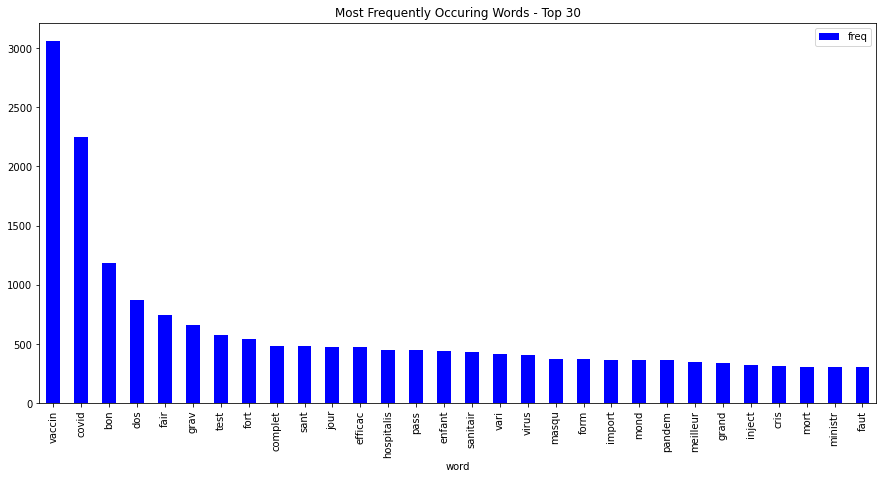

In [ ]:
sum_words = X_train_bow.sum(axis=0).tolist()
sum_words.extend(X_test_bow.sum(axis=0).tolist())
sum_words = np.array(sum_words)

words_freq = [(word, sum_words[0, i]) for word, i in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

#### *Bag-of-Words*

In [ ]:
pd1 = pd.DataFrame(X_train_bow.toarray())
pd2 = pd.DataFrame(X_test_bow.toarray())
bow_df = pd.concat([pd1, pd2])
bow_df.columns = vectorizer.get_feature_names()

#### Exportation (*Bag-of-Words*)

In [ ]:
bow_df.to_csv(export_dir + 'bow.csv', index = False)

In [ ]:
bow_df.sample(10)

,abaiss,abaissent,abandon,abandonnon,abat,abattag,abbatu,abbé,abeil,aberr,abject,abneg,aboient,abol,abon,abond,abondent,abord,about,abracadabr,abreuv,abri,absenc,absent,absenté,absolu,absten,abstinent,absurd,abus,abîm,academ,acce,acced,accel,accent,accentu,accept,acceptent,accepton,...,état,éteign,éteindr,étendr,étendu,étern,éternel,éternu,éthiqu,étiquet,étoff,étoil,éton,étouff,étrang,étre,étreint,étren,étron,étud,étudi,étudient,évacu,évalu,évaluent,éveil,éven,éventuel,évid,évident,évinc,évit,évitent,évolu,évoluent,évoqu,évoquent,évêqu,être,île
11909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5852,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
458,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2547,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3599,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11819,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Déclaration des fonctions de visualisation pour les vecteurs de mots

In [ ]:
def TSNE_plot_vocab(model):
  labels = []
  tokens = []

  for word in model.wv.index_to_key:
      tokens.append(model.wv[word])
      labels.append(word)
  
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23, n_jobs = cpu_count())
  new_values = tsne_model.fit_transform(tokens)

  x = []
  y = []
  for value in new_values:
    x.append(value[0])
    y.append(value[1])
      
  plt.figure(figsize=(16, 16)) 
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                xy=(x[i], y[i]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
  plt.show()

def TSNE_mots_similaires(model, word):
  arr = np.empty((0,300), dtype='f')
  word_labels = [word]
  nb_sim_words = 10
  close_words = model.wv.similar_by_word(word)[:nb_sim_words]

  arr = np.append(arr, np.array([model.wv[word]]), axis=0)
  for wrd_score in close_words:
    wrd_vector = model.wv[wrd_score[0]]
    word_labels.append(wrd_score[0])
    arr = np.append(arr, np.array([wrd_vector]), axis=0)

  tsne = TSNE(n_components=2, random_state=0)
  np.set_printoptions(suppress=True)
  Y = tsne.fit_transform(arr)

  x_coords = Y[:, 0]
  y_coords = Y[:, 1]

  color = ['red']
  for i in range(nb_sim_words):
    color.append('blue')

  plt.scatter(x_coords, y_coords, c = color)

  for label, x, y in zip(word_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(1, 5), textcoords='offset points')
  plt.xlim(min(x_coords)-100, max(x_coords)+100)
  plt.ylim(min(y_coords)-100, max(y_coords)+100)
  plt.show()

#### *Word2vec*

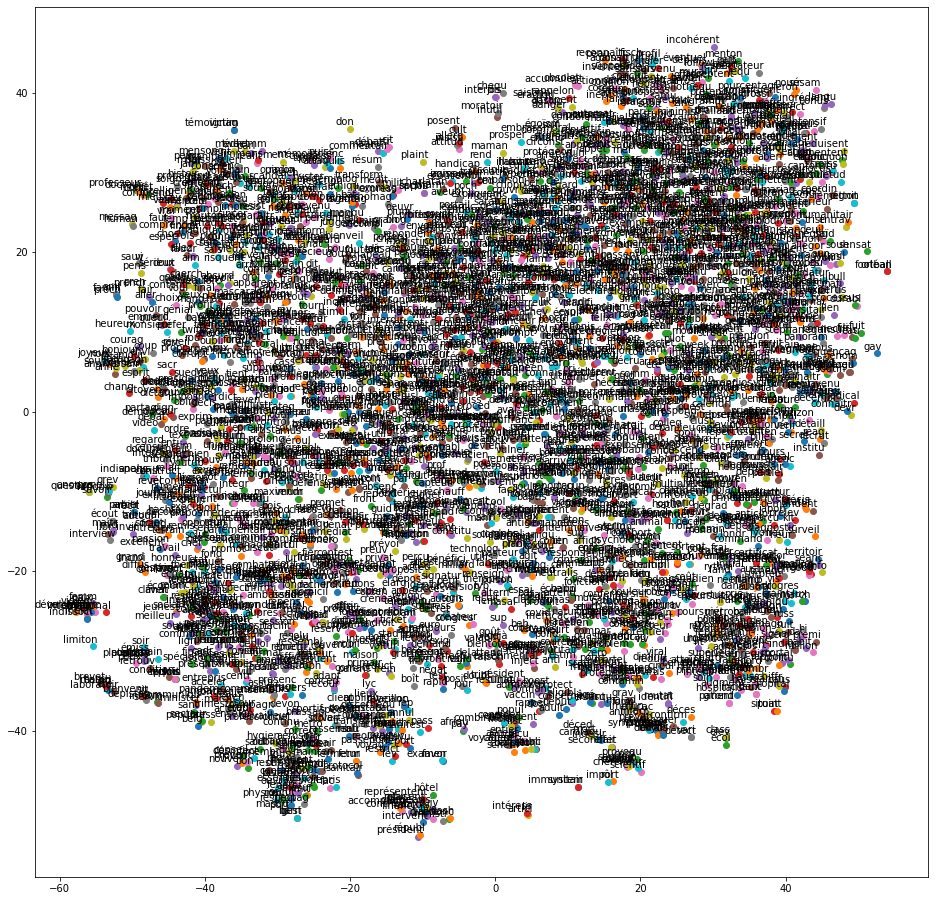

In [ ]:
TSNE_plot_vocab(w2vec_model)

In [ ]:
w2vec_model.wv.most_similar('vaccin')

[('dos', 0.8142922520637512),
 ('inject', 0.7717610597610474),
 ('éligibl', 0.7619686126708984),
 ('beb', 0.7366769909858704),
 ('inventeur', 0.725726842880249),
 ('list', 0.7246220707893372),
 ('recommand', 0.7178249955177307),
 ('veulent', 0.7167143225669861),
 ('résident', 0.7161878347396851),
 ('cliniqu', 0.7128190398216248)]

> Les mots les plus corrélés avec *vaccin* et leurs seuils de corrélation

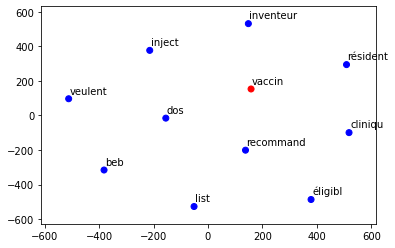

In [ ]:
TSNE_mots_similaires(w2vec_model, "vaccin")

#### *Fast Text*

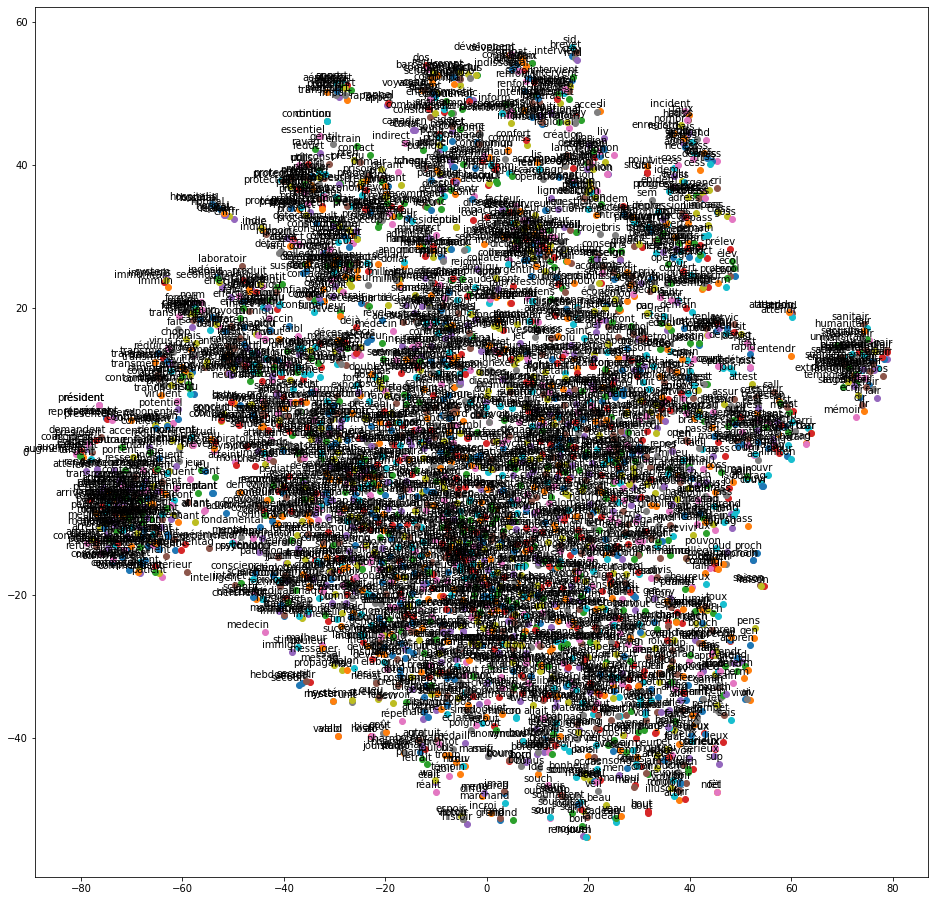

In [ ]:
TSNE_plot_vocab(fastText_model)

In [ ]:
fastText_model.wv.most_similar('vaccin')

[('dosag', 0.7983532547950745),
 ('dos', 0.7782460451126099),
 ('inject', 0.7738044261932373),
 ('vach', 0.7535533905029297),
 ('oser', 0.7336782813072205),
 ('gripp', 0.7198935151100159),
 ('observ', 0.7185039520263672),
 ('piqu', 0.716517448425293),
 ('cliniqu', 0.709195613861084),
 ('mult', 0.7082914113998413)]

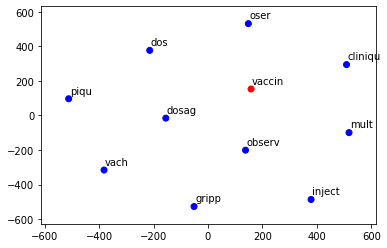

In [ ]:
TSNE_mots_similaires(fastText_model, "vaccin")

# Réduction de la dimensionnalité

## *Latent Semantic Analysis/Index*

> Nous utiliserons LSA pour réduire la dimensionnalité des données avant de les intégrer dans un modèle de l'apprentissage automatique.

### *Bag of words*

In [ ]:
print(f'dimension initiale {X_train_bow.shape[1]}')

dimension initiale 7628


#### Nous appliquons *LSA*

In [ ]:
lsa = TruncatedSVD(n_components=1500, n_iter=100, random_state=42)
lsa.fit(X_train_bow)

TruncatedSVD(n_components=1500, n_iter=100, random_state=42)

#### Informations

In [ ]:
lsa.explained_variance_ratio_.sum()

0.8767757778929868

> 87% de l'inertie est conservée après la réduction

#### Transformation

In [ ]:
X_train_bow_lsa = lsa.transform(X_train_bow)
X_test_bow_lsa = lsa.transform(X_test_bow)

### *Word2vec*

In [ ]:
print(f'dimension initiale {X_train_w2v.shape[1]}')

dimension initiale 300


In [ ]:
lsa = TruncatedSVD(n_components=50, n_iter=100, random_state=42)
lsa.fit(X_train_w2v)

TruncatedSVD(n_components=50, n_iter=100, random_state=42)

In [ ]:
lsa.explained_variance_ratio_.sum()

0.9989388775978336

> 99% de l'inertie est conservée après la réduction

In [ ]:
X_train_w2v_lsa = lsa.transform(X_train_w2v)
X_test_w2v_lsa = lsa.transform(X_test_w2v)

### *Fast Text*

In [ ]:
print(f'dimension initiale {X_train_ftxt.shape[1]}')

dimension initiale 300


In [ ]:
lsa = TruncatedSVD(n_components=50, n_iter=100, random_state=42)
lsa.fit(X_train_ftxt)

TruncatedSVD(n_components=50, n_iter=100, random_state=42)

In [ ]:
lsa.explained_variance_ratio_.sum()

0.9998778818765945

> 99% de l'inertie est conservée après la réduction

In [ ]:
X_train_ftxt_lsa = lsa.transform(X_train_ftxt)
X_test_ftxt_lsa = lsa.transform(X_test_ftxt)

# Entrainement du modèle

## Métriques

In [ ]:
metrics_bow = pd.DataFrame(
    columns = ['model', 'train accuracy', 'accuracy', 'f1', 'precision', 'recall']
)

metrics_w2v = pd.DataFrame(
    columns = ['model', 'train accuracy', 'accuracy', 'f1', 'precision', 'recall']
)

metrics_ftxt = pd.DataFrame(
    columns = ['model', 'train accuracy', 'accuracy', 'f1', 'precision', 'recall']
)

## *Linear Support Vector Machine*
> *Linear SVM* est plus compatible avec les données textuelles


#### Paramètres

- **loss**: La fonction de perte à utiliser. La valeur par défaut est "hinge", ce qui donne un SVM linéaire, la perte « log » donne une régression logistique, un classificateur probabiliste.
- **alpha**: Constante qui multiplie le terme de régularisation. Plus la valeur est élevée, plus la régularisation est forte.
- **penalty**: Spécifie la norme utilisée dans la pénalisation.

In [ ]:
param_svm = {
  "loss" : ["hinge", "log"],
  "alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
  "penalty" : ["l1", "l2"]
}

### *Bag-of-Words*

In [ ]:
svm_grid_bow = GridSearchCV(SGDClassifier(), param_svm, n_jobs = cpu_count())
svm_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=SGDClassifier(), n_jobs=2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [ ]:
model_svm_bow = svm_grid_bow.best_estimator_

In [ ]:
y_pred = model_svm_bow.predict(X_test_bow_lsa)

In [ ]:
metrics_bow.loc[len(metrics_bow)] = [
  'SVM',
  svm_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2vec*

In [ ]:
svm_grid_w2v = GridSearchCV(SGDClassifier(), param_svm, n_jobs = cpu_count())
svm_grid_w2v.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=SGDClassifier(), n_jobs=2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [ ]:
model_svm_w2v = svm_grid_w2v.best_estimator_

In [ ]:
y_pred = model_svm_w2v.predict(X_test_w2v_lsa)

In [ ]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'SVM',
  svm_grid_w2v.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Fast Text*

In [ ]:
svm_grid_ftxt = GridSearchCV(SGDClassifier(), param_svm, n_jobs = cpu_count())
svm_grid_ftxt.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=SGDClassifier(), n_jobs=2,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [ ]:
model_svm_ftxt = svm_grid_ftxt.best_estimator_

In [ ]:
y_pred = model_svm_ftxt.predict(X_test_ftxt_lsa)

In [ ]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'SVM',
  svm_grid_ftxt.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *Logistic Regression*

#### Paramètres

- **C**: Inverse de la force de régularisation ; doit être un flottant positif, les valeurs plus petites spécifient une régularisation plus forte.
- **solver**: L'algorithme à utiliser dans le problème d'optimisation.
- **penalty**: L2 "Ridge regression" ajoute la "magnitude au carré" du coefficient comme terme de pénalité à la fonction de perte.
- **max_iter**: Nombre maximal d'itérations nécessaires pour que les solveurs convergent.

In [ ]:
param_lr = {
  "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
  "solver": ['newton-cg', 'liblinear'],
  "penalty": ["l2"],
  "max_iter": [2000]
}

### *Bag-of-Words*

In [ ]:
lr_grid_bow = GridSearchCV(LogisticRegression(), param_lr, n_jobs = 4)
lr_grid_bow.fit(X_train_bow_lsa, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [ ]:
model_lr_bow = lr_grid_bow.best_estimator_

In [ ]:
y_pred = model_lr_bow.predict(X_test_bow_lsa)

In [ ]:
metrics_bow.loc[len(metrics_bow)] = [
  'Logistic Regression',
  lr_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2Vec*

In [ ]:
lr_grid_w2v = GridSearchCV(LogisticRegression(), param_lr, n_jobs = cpu_count())
lr_grid_w2v.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [ ]:
model_lr_w2v = lr_grid_w2v.best_estimator_

In [ ]:
y_pred = model_lr_w2v.predict(X_test_w2v_lsa)

In [ ]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'Logistic Regression',
  lr_grid_w2v.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *Fast Text*

In [ ]:
lr_grid_ftxt = GridSearchCV(LogisticRegression(), param_lr, n_jobs = cpu_count())
lr_grid_ftxt.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=2,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [2000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']})

In [ ]:
model_lr_ftxt = lr_grid_ftxt.best_estimator_

In [ ]:
y_pred = model_lr_ftxt.predict(X_test_ftxt_lsa)

In [ ]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'Logistic Regression',
  lr_grid_ftxt.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *Decision Tree*

#### Paramètres

- **criterion**: La fonction pour mesurer la qualité d'une division. Les critères pris en charge sont "gini" pour l'impureté Gini et "entropie" pour le gain d'information.
- **max_depth**: La profondeur maximale de l'arbre. Si None, les nœuds sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent moins de min_samples_split échantillons.

In [ ]:
param_dt = {
    'criterion': ['gini','entropy'],
    'max_depth': np.arange(3, 15)
}

### *Bag-of-Words*

In [ ]:
dt_grid_bow = GridSearchCV(DecisionTreeClassifier(), param_dt, n_jobs = cpu_count())
dt_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [ ]:
model_dt_bow = dt_grid_bow.best_estimator_

In [ ]:
y_pred = model_dt_bow.predict(X_test_bow_lsa)

In [ ]:
metrics_bow.loc[len(metrics_bow)] = [
  'Decision Tree',
  dt_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2Vec*

In [ ]:
dt_grid_w2v = GridSearchCV(DecisionTreeClassifier(), param_dt, n_jobs = cpu_count())
dt_grid_w2v.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [ ]:
model_dt_w2v = dt_grid_w2v.best_estimator_

In [ ]:
y_pred = model_dt_w2v.predict(X_test_w2v_lsa)

In [ ]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'Decision Tree',
  dt_grid_w2v.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Fast Text*

In [ ]:
dt_grid_ftxt = GridSearchCV(DecisionTreeClassifier(), param_dt, n_jobs = cpu_count())
dt_grid_ftxt.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [ ]:
model_dt_ftxt = dt_grid_ftxt.best_estimator_

In [ ]:
y_pred = model_dt_ftxt.predict(X_test_ftxt_lsa)

In [ ]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'Decision Tree',
  dt_grid_ftxt.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

## *KNN - K-Nearest Neighbors*

#### Paramètres

- weights: Fonction de pondération utilisée dans la prédiction.
          ‘uniforme’ : poids uniformes. Tous les points de chaque voisinage sont pondérés de manière égale.
          ‘distance’ : les voisins les plus proches d'un point de requête auront une plus grande influence que les voisins qui sont plus éloignés.
- n_neighbors: range(1, 31) Nombre de voisins à utiliser

In [ ]:
param_knn = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': range(1, 31)
}

### *Bag-of-Words*

In [ ]:
knn_grid_bow = GridSearchCV(KNeighborsClassifier(), param_knn, n_jobs = cpu_count()) 
knn_grid_bow.fit(X_train_bow_lsa, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']})

In [ ]:
model_knn_bow = knn_grid_bow.best_estimator_

In [ ]:
y_pred = model_knn_bow.predict(X_test_bow_lsa)

In [ ]:
metrics_bow.loc[len(metrics_bow)] = [
  'KNN',
  knn_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Word2Vec*

In [ ]:
knn_grid_bow = GridSearchCV(KNeighborsClassifier(), param_knn, n_jobs = cpu_count()) 
knn_grid_bow.fit(X_train_w2v_lsa, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']})

In [ ]:
model_knn_w2v = knn_grid_bow.best_estimator_

In [ ]:
y_pred = model_knn_w2v.predict(X_test_w2v_lsa)

In [ ]:
metrics_w2v.loc[len(metrics_w2v)] = [
  'KNN',
  knn_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

### *Fast Text*

In [ ]:
knn_grid_bow = GridSearchCV(KNeighborsClassifier(), param_knn, n_jobs = cpu_count()) 
knn_grid_bow.fit(X_train_ftxt_lsa, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=2,
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']})

In [ ]:
model_knn_ftxt = knn_grid_bow.best_estimator_

In [ ]:
y_pred = model_knn_ftxt.predict(X_test_ftxt_lsa)

In [ ]:
metrics_ftxt.loc[len(metrics_ftxt)] = [
  'KNN',
  knn_grid_bow.best_score_,
  accuracy_score(y_test, y_pred),
  f1_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  precision_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
  recall_score(y_test, y_pred, average = 'weighted', labels = np.unique(y_pred)),
]

# Evaluation

## *Bag-of-Words*

In [ ]:
metrics_bow

,model,train accuracy,accuracy,f1,precision,recall
0,SVM,0.742875,0.743467,0.723145,0.731982,0.743467
1,Logistic Regression,0.741655,0.749511,0.734767,0.737909,0.749511
2,Decision Tree,0.683052,0.677511,0.608178,0.671681,0.677511
3,KNN,0.715516,0.719289,0.683230,0.710241,0.719289


## *Word2Vec*

In [ ]:
metrics_w2v

,model,train accuracy,accuracy,f1,precision,recall
0,SVM,0.689453,0.692267,0.653441,0.670734,0.692267
1,Logistic Regression,0.693874,0.692089,0.642268,0.668215,0.692089
2,Decision Tree,0.683738,0.678400,0.632950,0.657822,0.678400
3,KNN,0.718641,0.721067,0.683531,0.715888,0.721067


## *Fast Text*

In [ ]:
metrics_ftxt

,model,train accuracy,accuracy,f1,precision,recall
0,SVM,0.687549,0.679289,0.642705,0.652459,0.679289
1,Logistic Regression,0.690825,0.686933,0.635147,0.662405,0.686933
2,Decision Tree,0.680841,0.672533,0.599143,0.646334,0.672533
3,KNN,0.718413,0.722667,0.687076,0.718081,0.722667


## Visualisation

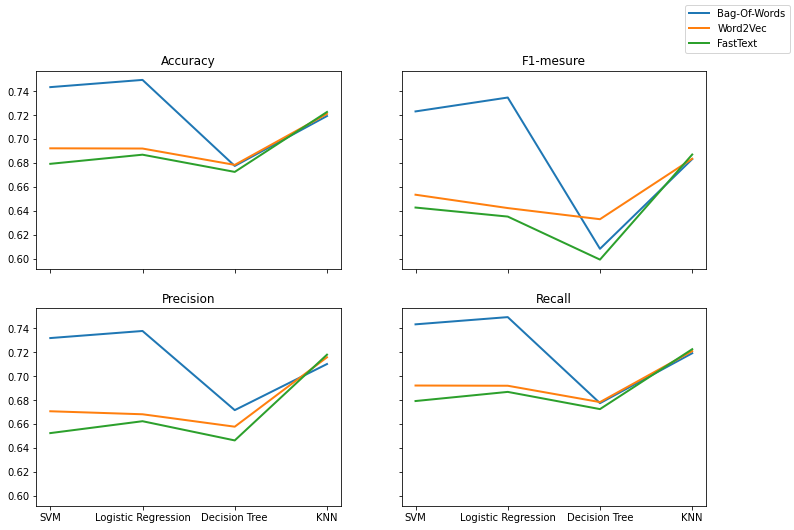

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(12,8), sharey = True, sharex = True)

axes[0, 0].plot(metrics_bow['model'], metrics_bow['accuracy'], linestyle='solid', linewidth=2, label = 'Bag-Of-Words')
axes[0, 0].plot(metrics_w2v['model'], metrics_w2v['accuracy'], linestyle='solid', linewidth=2, label = 'Word2Vec')
axes[0, 0].plot(metrics_ftxt['model'], metrics_ftxt['accuracy'], linestyle='solid', linewidth=2, label = 'FastText')
axes[0, 0].set_title('Accuracy')

axes[0, 1].plot(metrics_bow['model'], metrics_bow['f1'], linestyle='solid', linewidth=2)
axes[0, 1].plot(metrics_w2v['model'], metrics_w2v['f1'], linestyle='solid', linewidth=2)
axes[0, 1].plot(metrics_ftxt['model'], metrics_ftxt['f1'], linestyle='solid', linewidth=2)
axes[0, 1].set_title('F1-mesure')

axes[1, 0].plot(metrics_bow['model'], metrics_bow['precision'], linestyle='solid', linewidth=2)
axes[1, 0].plot(metrics_w2v['model'], metrics_w2v['precision'], linestyle='solid', linewidth=2)
axes[1, 0].plot(metrics_ftxt['model'], metrics_ftxt['precision'], linestyle='solid', linewidth=2)
axes[1, 0].set_title('Precision')

axes[1, 1].plot(metrics_bow['model'], metrics_bow['recall'], linestyle='solid', linewidth=2)
axes[1, 1].plot(metrics_w2v['model'], metrics_w2v['recall'], linestyle='solid', linewidth=2)
axes[1, 1].plot(metrics_ftxt['model'], metrics_ftxt['recall'], linestyle='solid', linewidth=2)
axes[1, 1].set_title('Recall')

f.legend()
f.show()